In [12]:
%run training_functions.ipynb

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
['train', 'validation', 'test']
['train', 'validation', 'test']
In, Out, get_ipython, exit, quit, open, accelerate, datasets, evaluate, math, np, os, peft, pickle, pytest, ipytest, pd, transformers, torch, time, threading, load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names, LoftQConfig, LoraConfig, get_peft_model, AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, Trainer, SFTTrainer, SFTConfig, @py_builtins, @pytest_ar, model_from_pkl, ds_builder1, ds_builder2, ds_builder3, ds_gs, ds_gst1_train, ds_gst1_test, ds_gst2_train, ds_gst2_test, search_with_strings, map_data, print_trainable_parameters, metric, initialize_heartbeat, heartbeat, end_heartbeat, comp_metrics_output, compute_metrics, make_trainer, get_dataframe, get_training_output, lla_321, lla_321_tokenizer, lla_323, 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [2]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B-Instruct")

In [3]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B-Instruct")

In [4]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)

In [5]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [6]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

Map: 100%|███████████████| 7500/7500 [05:27<00:00, 22.91 examples/s]


In [7]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [8]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [9]:
l_trainer = make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=20))

In [10]:
state=initialize_heartbeat()
l_trainer.train() 
end_heartbeat(state)

The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss
20,0.674100,2.688479
40,0.666300,2.655928
60,0.658600,2.635938
80,0.655500,2.623807
100,0.651600,2.615537
120,0.651600,2.610037
140,0.649000,2.605709
160,0.646800,2.602380
180,0.646800,2.599402
200,0.645900,2.597108


The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running
The function is running
The function is running
The function is running


,loss,eval_loss
steps,,
20,0.6741,2.688479
40,0.6663,2.655928
60,0.6586,2.635938
80,0.6555,2.623807
100,0.6516,2.615537
120,0.6516,2.610037
140,0.6490,2.605709
160,0.6468,2.602380
180,0.6468,2.599402


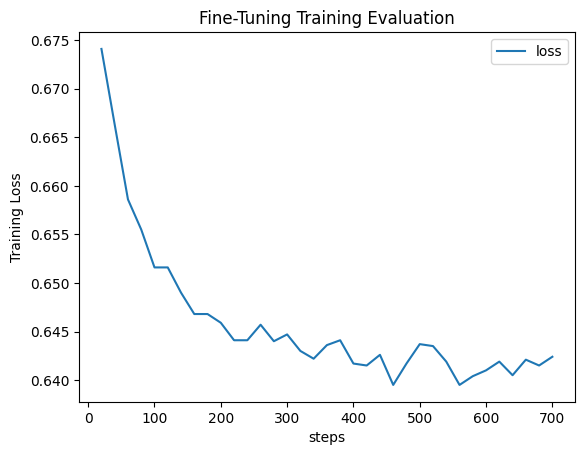

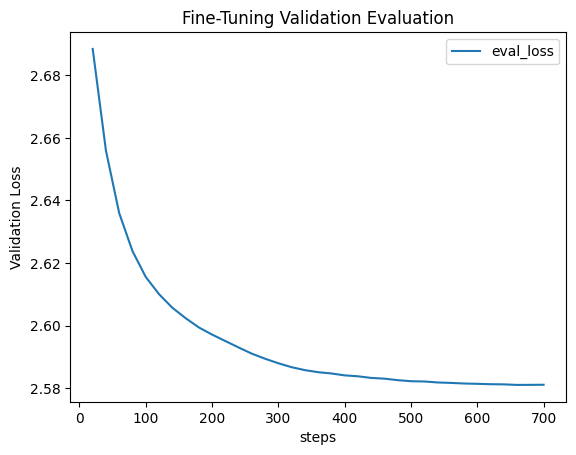

In [13]:
output=get_training_output(l_trainer, ['loss', 'eval_loss'])
#output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [14]:
l2_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=5))

In [15]:
state=initialize_heartbeat()
l2_trainer.train() 
end_heartbeat(state)

The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.638000,2.576230
2,0.637800,2.574296
3,0.637600,2.573564


The function is running
The function is running
The function is running
The function is running
The function is running
The function is running
The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


The function is running
The function is running


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,loss,eval_loss
epoch,,
1.0,0.6380,2.576230
2.0,0.6378,2.574296
3.0,0.6376,2.573564


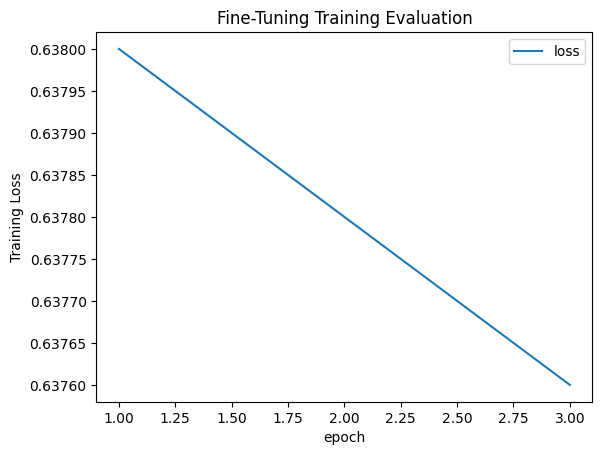

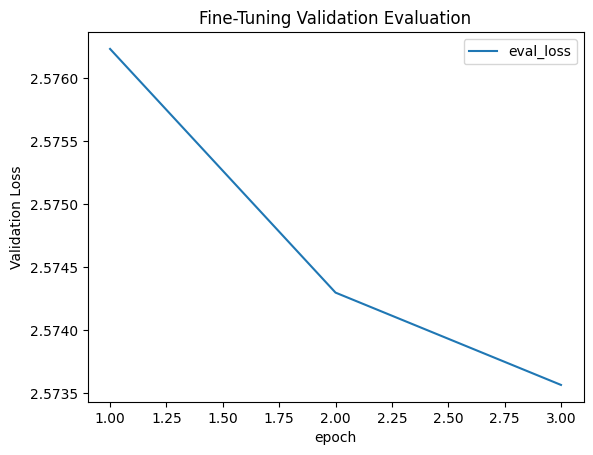

In [16]:
output=get_training_output(l2_trainer, ['loss', 'eval_loss']) # for larger numbers of parameters, don't run compute_metrics for now
#output=get_training_output(l2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [17]:
l_trainer.model.save_pretrained('./fine_tuned/lla/')
l2_trainer.model.save_pretrained('./fine_tuned/lla2/')

In [18]:
l_trainer.processing_class.save_pretrained('./fine_tuned/lla_token/')
l2_trainer.processing_class.save_pretrained('./fine_tuned/lla2_token/')

('./fine_tuned/lla2_token/tokenizer_config.json',
 './fine_tuned/lla2_token/special_tokens_map.json',
 './fine_tuned/lla2_token/tokenizer.json')